# Initialisation

Nous visons à développer un modèle de segmentation de la clientèle afin d'améliorer les processus de prise de décision dans le secteur du commerce de détail

Notre objectif est de convertir les données transactionnelles en un ensemble de données axées sur le client en créant de nouvelles caractéristiques. Cela facilitera la segmentation des clients en groupes distincts à l'aide de certains algorithmes de regroupement dont on effectuera la comparaison, nous permettant ainsi de mieux comprendre les profils et les préférences des différents groupes de clients.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px

from scipy.stats import linregress

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.kernel_approximation import RBFSampler, PolynomialCountSketch
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, explained_variance_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from scipy.special import rel_entr

**Dataset Description**

Cet ensemble de fichiers contiennent des données de comportement pour 5 mois (oct 2019 - fév 2020) d'une boutique en ligne de cosmétiques de taille moyenne collectées par le projet Open CDP.
[link data](https://www.kaggle.com/datasets/mkechinov/ecommerce-events-history-in-cosmetics-shop?select=2019-Dec.csv)


Les fichiers contiennent 9 colonnes et environ 4 millions de lignes chacun


*   event_time    : date et temps de l'événement
*   event_type    : Type d'événement : l'un des éléments suivants
      * view : un utilisateur a consulté un produit
      * cart : un utilisateur a ajouté un produit à son panier
      * remove_from_cart : un utilisateur a retiré un produit du panier d'achat
      * purchase : un utilisateur a acheté un produit
*   product_id    : Code attribué de manière unique à chaque produit distinct
*   category_id   : Code attribué de manière unique à chaque catégorie distincte
*   category_code : libellé des catégories
*   brand         : les marques
*   price         : Le prix unitaire du produit en dollars
*   user_id       : Identifiant attribué de manière unique à chaque client
*   user_session  : ID de session de l'utilisateur temporaire. Identique pour chaque session d'utilisateur. Il est modifié chaque fois que l'utilisateur revient dans le magasin en ligne après une longue pause.



> En chaque fichier on ne va selectionner que les types d'événement ( ***cart , purchase*** ) pour analyser ces deux comportements, puis les combiner en un seul fichier qui va d'octobre 2019 à février 2020.


In [ ]:
file_paths = ['2019-Oct.csv', '2019-Nov.csv', '2019-Dec.csv', '2020-Jan.csv', '2020-Feb.csv']

filtered_dfs = []

# Fonction permettant de filtrer et d'importer des données à partir d'un seul fichier
def filter_data_from_file(file_path):
    filtered_chunks = []
    chunksize = 10000

    for chunk in pd.read_csv(file_path, chunksize=chunksize):
        filtered_chunk = chunk[chunk['event_type'].isin(['cart', 'purchase'])]
        filtered_chunks.append(filtered_chunk)

    return pd.concat(filtered_chunks, ignore_index=True)

# Traiter chaque fichier et collecter les DataFrames filtrées
for file_path in file_paths:
    filtered_df = filter_data_from_file(file_path)
    filtered_dfs.append(filtered_df)

# Concaténer tous les DataFrames filtrés de tous les fichiers
final_df = pd.concat(filtered_dfs, ignore_index=True)

In [ ]:
final_df.to_csv("eCommerce-Cosmetics-Shop.csv")

In [ ]:
final_df.shape

(7055340, 9)

# Analyse initiale des données
En cette étape, je vais acquérir une compréhension approfondie de l'ensemble de données avant de passer aux étapes de nettoyage et de transformation des données.

## Aperçu de l'ensemble de données

Je vais d'abord effectuer une analyse préliminaire pour comprendre la structure et les types de colonnes de données

In [ ]:
df = pd.read_csv("eCommerce-Cosmetics-Shop.csv", index_col=0)

In [ ]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,cart,5773203,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
1,2019-10-01 00:00:03 UTC,cart,5773353,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2,2019-10-01 00:00:07 UTC,cart,5881589,2151191071051219817,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
3,2019-10-01 00:00:07 UTC,cart,5723490,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
4,2019-10-01 00:00:15 UTC,cart,5881449,1487580013522845895,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9


In [ ]:
df.shape

(7055340, 9)

In [ ]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 6935748 entries, 0 to 7055339
Data columns (total 9 columns):
 #   Column        Non-Null Count    Dtype              
---  ------        --------------    -----              
 0   event_time    6935748 non-null  datetime64[ns, UTC]
 1   event_type    6935748 non-null  object             
 2   product_id    6935748 non-null  object             
 3   category_id   6935748 non-null  object             
 4   brand         3948408 non-null  object             
 5   price         6935748 non-null  float64            
 6   user_id       6935748 non-null  object             
 7   user_session  6935748 non-null  object             
 8   order_status  6935748 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), object(7)
memory usage: 529.2+ MB


**Déductions :**

> L'ensemble de données comprend 7 055 340 entrées et 9 colonnes. Voici un bref aperçu de chaque colonne :

*   **event_time** : Colonne de type *objet* qui enregistre la date et l'heure de chaque transaction. nécessite changement en type *date*
*   **event_type** : Colonne de type *objet* qui contient la description du type de l'événement. Chaque ligne peut représenter soit l'événement d'ajout au panier soit l'événement d'achat.  
*   **product_id** : Colonne de type *entier* représentant le code produit de chaque article.
*   **category_id** : Colonne de type *entier* représentant le code de chaque catégorie.
*   **category_code** : Colonne de type *objet*, contient des libellés des produits. Elle comporte plusieurs valeurs manquantes, avec juste 85 445 entrées non nulles sur 7 055 340.
*   **brand** : Colonne de type *objet*, contient les noms des marques des produits. Elle comporte quelques valeurs manquantes, avec 4 011 941 entrées non nulles sur 7 055 340.
*   **price** : Colonne de type *décimal* représentant le prix unitaire de chaque produit.
*   **user_id** : Colonne de type *entier* qui contient l'identifiant du client pour chaque événement.
*   **user_session** : Colonne de type *objet*, contient les sessions temporaires de chaque utilisateur. Elle comporte quelques valeurs manquantes, avec 7 051 564 entrées non nulles sur 7 055 340.

> D'après un premier aperçu, il semble qu'il manque des valeurs dans les colonnes *brand*, *category_code*, *user_session* ce qui doit être corrigé. La colonne *event_time* n'est pas au format datetime, ce qui doit être corrigé pour faciliter l'analyse ultérieure des séries chronologiques.
Les colonnes concernant tous les ids sont de type *entier*, prévoir un changement de type en *objet* pour une analyse statistique plus souple, pouvoir déterminer les ids uniques et les plus fréquents entre autres.
Nous observons également qu'un même client peut avoir plusieurs événement, comme le montre la répétition de l'identifiant du client dans les premières lignes.

> Les prochaines étapes consisteront à approfondir le nettoyage et le prétraitement des données afin de traiter les valeurs manquantes et les données potentiellement erronées.Puis de créer de nouvelles variables susceptibles de contribuer à la réalisation des objectifs du projet.


## Résumé des statistiques

Je vais maintenant générer des statistiques afin d'obtenir un premier aperçu de la distribution des données :

In [ ]:
columns_to_change_type = ['product_id', 'category_id', 'user_id']
df[columns_to_change_type] = df[columns_to_change_type].astype('object')

df['event_time'] = pd.to_datetime(df['event_time'])

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,7055340.0,5.136472,10.252962,-79.37,1.59,3.02,5.54,327.78


In [ ]:
df['event_time'].describe().reset_index(drop=False).set_index('index').T

index,count,mean,min,25%,50%,75%,max
event_time,7055340,2019-12-14 19:19:05.329430016+00:00,2019-10-01 00:00:00+00:00,2019-11-07 09:04:34.500000+00:00,2019-12-10 14:42:54+00:00,2020-01-24 17:54:01.750000128+00:00,2020-02-29 23:59:39+00:00


In [ ]:
df.describe(include='object').T

,count,unique,top,freq
event_type,7055340,2,cart,5768333
product_id,7055340,46185,5809910,35651
category_id,7055340,473,1487580007675986893,399699
category_code,85445,11,stationery.cartrige,29719
brand,4011941,253,runail,603226
user_id,7055340,399219,527021202,4292
user_session,7051564,1015108,74206ba1-c863-4760-bbdc-b11777059e46,3749


**Déductions :**



*   **price :**
    *   Le prix unitaire moyen des produits est d'environ 5.13.
    *   Le prix unitaire présente également une valeur minimale de -79.37, ce qui suggère la présence d'erreurs ou de bruit dans les données, car les prix négatifs n'ont pas de sens.
    *   La présence de possibles valeurs aberrantes est indiquée par une différence entre les valeurs maximales et les valeurs du 75e percentile.

*   **event_time :**
    *   La date minimale présente une valeur de 2019-10-01, et une valeur maximale de 2020-02-29 ce qui respecte la description des fichiers, des données d'achat d'Octobre 2019 à Février 2020

*   **event_type :**
    *   Il y a 2 types d'événements uniques.
    *   Le type d'évéement le plus fréquent est le "cart", qui apparaît 5 768 333 fois, ce qui peut correspondre au fait que les clients ajoute sur le panier et ne procéde pas à l'achat.

*   **product_id :**
    *   Il existe 46 185 codes de produit uniques représentant différents produits.
    *   Le code produit le plus fréquent est 5809910, apparaissant 35651 fois.

*   **category_id :**
    *   Il existe 473 codes uniques représentant différents catégories.
    *   Le code catégorie le plus fréquent est 1487580007675986893, apparaissant 399 699 fois.

*   **category_code :**
    *   Il y a 11 libellés de produits uniques.
    *   Le libellé le plus fréquent est "stationery.cartrige", apparaissant 29 719 fois.


*   **brand**
    *   Il existe 253 marques différentes.
    *   La marque la fréquente est "runail", apparaissant 603 226 fois.

*   **user_id**
    *   Il existe 399 219 clients uniques.
    *   Le client le plus fréquent est 527021202, apparaissant 4 292, ce qui peut correspondre à plusieurs événements incluant plusieurs articles.


# Nettoyage et transformation des données

Cette étape comprend un processus complet de nettoyage et de transformation afin d'affiner l'ensemble des données. Il s'agit de traiter les valeurs manquantes, de gérer les entrées en double, de corriger les anomalies dans les codes et ........... et de procéder à d'autres ajustements nécessaires pour préparer les données en vue d'une analyse et d'une modélisation approfondies.


## Traitement des valeurs manquantes

Dans un premier temps, je déterminerai le pourcentage de valeurs manquantes dans chaque colonne, puis je choisirai la stratégie la plus efficace pour y remédier :

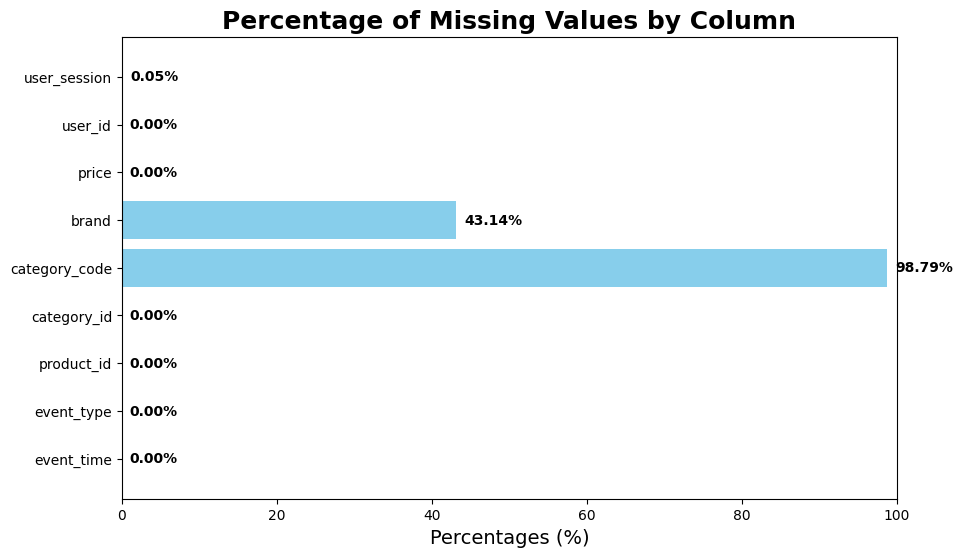

In [ ]:
# Calculer le pourcentage de valeurs manquantes pour chaque colonne
missing_percentage = df.isnull().mean() * 100

# Tracer le résultat
plt.figure(figsize=(10, 6))
bars = plt.barh(missing_percentage.index, missing_percentage, color='skyblue')

# Annoter les valeurs et les index
for bar in bars:
    plt.text(bar.get_width()+1, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}%', va='center',ha='left',fontweight='bold')

plt.xlim(0, 100)
plt.xlabel('Percentages (%)',fontsize=14)
plt.title('Percentage of Missing Values by Column',fontweight='bold', fontsize=18)
# plt.gca().invert_yaxis()
plt.show()

**Stratégie de traitement des valeurs manquantes :**



*   **user_session** ( 0.05% valeurs manquantes )
    *    La colonne présente un très faible pourcentage de valeurs manquantes. Toutefois, il a été remarqué que le ID de la session temporaire est  identique pour chaque session d'utilisateur mais qu'il est modifié chaque fois que l'utilisateur revient dans le magasin en ligne après une longue pause. Cela pourrait nous aider à déterminer ce que représente une longue pause et qui sont les utilisateurs qui reviennent.
    *    Comme le pourcentage de données manquantes est assez faible, la suppression des lignes dont ID session est manquant semble être l'approche la plus raisonnable.

*   **brand** ( 43.14% valeurs manquantes )
    *  Imputer à partir de product_id ???
    
*   **category_code** ( 98.79% valeurs manquantes )
    *    La colonne contient un fort pourcentage, presque la totalité, de valeurs manquantes.
    *    La suppression de la colonne semle être l'approche la plus correcte.

In [ ]:
# Suppression de la colonne "category_id"
df.drop("category_code", axis=1, inplace=True)

In [ ]:
# Suppression des lignes contenant des valeurs manquantes dans la colonne "user_session"
df.dropna(subset="user_session", inplace=True)

In [ ]:
df.isna().sum()

event_time            0
event_type            0
product_id            0
category_id           0
brand           3042073
price                 0
user_id               0
user_session          0
dtype: int64

## Gestion des doublons

Dans le cadre de ce projet, la présence de lignes totalement identiques, y compris des heures d'événelent identiques, suggère qu'il pourrait s'agir de véritables transactions répétées plutôt que d'erreurs d'enregistrement des données. Ils pourraient être utilisés pour définir la quantité du même produit ajouté au panier ou acheté. Mais puisqu'on a pas récupérer les types d'événements 'remove_from_cart' pour connaitre les articles qui ont été enlevé du panier avant achat, j'opte donc pour la suppression de ces lignes dupliquées totalement identiques.

In [ ]:
#  Recherche des lignes en double (en conservant toutes les instances)
duplicated_ = df[df.duplicated(keep=False)]

In [ ]:
# Trier les données en fonction de certaines colonnes pour voir les lignes dupliquées les unes à côté des autres
duplicated_[duplicated_["order_status"]=="completed"].sort_values("product_id").tail(20)

,event_time,event_type,product_id,category_id,brand,price,user_id,user_session,order_status
6672528,2020-02-21 14:43:20+00:00,cart,5925358,1487580007675986893,NaN,1.43,598849908,1b73e8d4-e3ce-4d1a-b1cf-ac9929a933e9,completed
6672527,2020-02-21 14:43:20+00:00,cart,5925358,1487580007675986893,NaN,1.43,598849908,1b73e8d4-e3ce-4d1a-b1cf-ac9929a933e9,completed
6672524,2020-02-21 14:43:13+00:00,cart,5925362,1487580007675986893,NaN,1.43,598849908,1b73e8d4-e3ce-4d1a-b1cf-ac9929a933e9,completed
6672523,2020-02-21 14:43:13+00:00,cart,5925362,1487580007675986893,NaN,1.43,598849908,1b73e8d4-e3ce-4d1a-b1cf-ac9929a933e9,completed
7037757,2020-02-29 16:30:26+00:00,cart,5925888,1487580007306888126,NaN,4.76,453970378,7f47be06-703a-4d37-ac24-83f6bd01aad2,completed
7037759,2020-02-29 16:30:26+00:00,cart,5925888,1487580007306888126,NaN,4.76,453970378,7f47be06-703a-4d37-ac24-83f6bd01aad2,completed
6823731,2020-02-25 08:12:35+00:00,cart,5926439,1487580006317032337,NaN,8.73,614907313,72611b19-471f-4c18-a0b6-8b7d4cf64522,completed
6823730,2020-02-25 08:12:35+00:00,cart,5926439,1487580006317032337,NaN,8.73,614907313,72611b19-471f-4c18-a0b6-8b7d4cf64522,completed
6331431,2020-02-14 02:21:15+00:00,cart,5927458,1487580007675986893,NaN,1.59,614076378,0ecad292-4131-4375-889b-a02fa896eebd,completed
6331432,2020-02-14 02:21:15+00:00,cart,5927458,1487580007675986893,NaN,1.59,614076378,0ecad292-4131-4375-889b-a02fa896eebd,completed


In [ ]:
# Suppression des lignes en double
df.drop_duplicates(inplace=True)

## Traitement des prix unitaires négatifs
Comme vu précédemment le prix unitaire présente une valeur minimale de -79.37, ce qui suggère la présence d'erreurs ou de bruit dans les données, car les prix négatifs n'ont pas de sens.
Une analyse détaillée des produits associées à des prix unitaires nuls sera effectuée afin de déterminer si elles correspondent à un modèle spécifique.

In [ ]:
df[(df["price"]<0)].describe()

,price
count,119.000000
mean,-30.879328
std,20.505334
min,-79.370000
25%,-47.620000
50%,-23.810000
75%,-15.870000
max,-7.940000


In [ ]:
df[(df["price"]<0)].describe(include='object').T

,count,unique,top,freq
event_type,119,1,purchase,119
product_id,119,5,5670257,34
category_id,119,1,1487580014042939619,119
brand,0,0,NaN,NaN
user_id,119,108,516725846,2
user_session,119,112,d243bb1b-2ee9-4c21-9b2a-6460469e9a75,2
order_status,119,1,completed,119


In [ ]:
df[df["price"]<0]['product_id'].unique()

array([5716857, 5716855, 5716859, 5670257, 5716861], dtype=object)

In [ ]:
df[df['product_id']==5716855]

,event_time,event_type,product_id,category_id,brand,price,user_id,user_session,order_status
86496,2019-10-02 08:30:03+00:00,purchase,5716855,1487580014042939619,NaN,-7.94,550375225,5ddec778-9464-4514-914d-be7b751b8e2c,completed
524087,2019-10-09 14:49:14+00:00,purchase,5716855,1487580014042939619,NaN,-7.94,514562574,fed2aeb4-0c75-44f7-9ca8-1a8be8214779,completed
567968,2019-10-10 14:33:29+00:00,purchase,5716855,1487580014042939619,NaN,-7.94,558797258,a406cf28-f04b-4361-8e6a-c62d36045e07,completed
1502775,2019-11-01 15:36:23+00:00,purchase,5716855,1487580014042939619,NaN,-7.94,566480066,34fa4291-9e2e-470f-a678-b84d9bbbdfe3,completed
2874972,2019-11-27 16:17:31+00:00,purchase,5716855,1487580014042939619,NaN,-7.94,395032118,dad52920-321a-4d0d-805e-e83ff813d994,completed
3814595,2019-12-17 10:37:03+00:00,purchase,5716855,1487580014042939619,NaN,-7.94,584498077,ecbf0f7c-3c10-42e8-9af6-1397b5428afa,completed
4193086,2019-12-28 15:42:00+00:00,purchase,5716855,1487580014042939619,NaN,-7.94,539714006,e1d8e3b7-1309-475b-aaaa-4a12ac841c3e,completed
4572613,2020-01-09 15:30:54+00:00,purchase,5716855,1487580014042939619,NaN,-7.94,595669649,e6201baf-9642-4b88-983d-2b722d3530a7,completed
5001209,2020-01-18 15:15:17+00:00,purchase,5716855,1487580014042939619,NaN,-7.94,602860849,38f2250a-e5b4-4386-a41d-218580abdee1,completed
5956961,2020-02-06 11:23:28+00:00,purchase,5716855,1487580014042939619,NaN,-7.94,370220114,86c95b0c-df23-474e-b8a9-9284639e772a,completed


**Déductions :**

*  Les lignes avec un prix unitaire négatif sont relativement peu nombreuses (119 lignes)
*  Ces prix négatifs concernent exactement 5 produits distincts dont les marques sont toutes nulles et le type d'événement achat.
*  Inclure ces événements dans l'analyse de regroupement risque d'introduire du bruit et de fausser les modèles de comportement des clients identifiés par l'algorithme de regroupement.

> Compte tenu du petit nombre de ces événements et de leur potentiel à introduire du bruit dans l'analyse des données, la stratégie est donc de supprimer ces lignes de l'ensemble de données. Cela permettrait de conserver un ensemble de données plus propre et plus cohérent, ce qui est essentiel pour construire un modèle de regroupement précis et fiable.

In [ ]:
df = df[df['price']>0]

In [ ]:
df.describe()

,price
count,6.898271e+06
mean,5.196060e+00
std,1.027125e+01
min,5.000000e-02
25%,1.590000e+00
50%,3.140000e+00
75%,5.560000e+00
max,3.277800e+02


## Traitement de la colonne 'event_type'

Pour affiner notre compréhension du comportement et des préférences des clients, nous devons prendre en compte les événements où il y a eu ajout au panier puis aucun achat en d'autre terme des événements qui ont été annulées. Dans un premier temps, nous identifierons ces commandes en filtrant les lignes dont le type d'événement est à la fois 'cart' et 'purchase', étant donné qu'avant de valider l'achat il y a forcément ajout au panier. Par la suite, nous analyserons ces lignes:

In [ ]:
# Trouver les numéros de produit qui n'ont que des événements "purchase"
# C'est un comportement très peu probable d'avoir un achat sans ajout au panier, comme démontrer par la taille de cette liste.
# Peut être que c'est une erreur
# On va quand même considérer que c'est un achat

products_only_purchase = df.groupby('product_id').filter(lambda x: set(x['event_type']) == {'purchase'})['product_id'].unique()
display(products_only_purchase)
display(len(products_only_purchase))

array([5759135, 5816583, 5788723, 5882340, 5663195, 5716857, 5716855,
       5882324, 5716859, 5670257, 5765723, 5701839, 5716861, 5901814,
       5746669, 5910146, 5910156, 5828045, 5861351, 5840149, 5840165,
       5680392, 5695547, 5862008, 5869588, 5841355, 5659641, 5926337],
      dtype=object)

28

In [ ]:
#  Filtrez les lignes dont le 'product_id', 'user_id', 'user_session' ont deux type d'événement
#  Créez une nouvelle colonne indiquant le statut de la commande.

def determine_order_status(events):
    if 'purchase' in events and 'cart' in events:
        return 'completed'
    elif 'purchase' in events:
        return 'completed'
    else:
        return 'cancelled'

df['order_status'] = df.groupby(['product_id', 'user_id', 'user_session'])['event_type'].transform(lambda x: determine_order_status(set(x)))

In [ ]:
df.sample(20)

,event_time,event_type,product_id,category_id,brand,price,user_id,user_session,order_status
6209298,2020-02-11 16:19:20+00:00,cart,5808560,1487580011996119176,irisk,4.44,343695499,d82aced5-b5bb-4eeb-8365-c04fe90cc0af,canceled
4535552,2020-01-08 19:20:46+00:00,purchase,5911259,1487580005092295511,runail,3.02,472780506,6c517bb2-1665-42ec-9977-7909a5fcd597,completed
5006292,2020-01-18 17:20:35+00:00,cart,5884212,1487580005092295511,NaN,10.63,538991972,fbdf03ca-a8fb-49da-a9f0-9df7df469fc3,canceled
1108868,2019-10-23 10:12:05+00:00,cart,5819231,1487580005713052531,ingarden,4.44,541361597,1382baea-be59-4680-a78e-df96acedd978,canceled
4666594,2020-01-11 18:49:43+00:00,purchase,5801772,1487580005671109489,masura,1.73,599137670,54d4d552-fd71-4b96-b7fb-1901cba48fcb,completed
1939118,2019-11-10 13:58:12+00:00,cart,5760765,1487580005134238553,runail,2.62,543934944,4753ac01-ebfd-4ae1-b571-c4bd11ab3772,canceled
6666541,2020-02-21 12:14:13+00:00,cart,5686081,1487580008145748965,NaN,0.57,618337197,2dcff9cd-953e-418e-8e91-2f09d81dbfb4,canceled
5403104,2020-01-27 09:41:36+00:00,purchase,5903991,1487580007675986893,NaN,1.59,551029890,6bcf364d-45fe-4d3a-a021-28a3e4356d8e,completed
6475755,2020-02-17 11:53:32+00:00,cart,5857007,1487580009496313889,runail,3.17,616169171,38d70494-2d82-4474-8c65-8355250880be,canceled
3486079,2019-12-09 18:14:40+00:00,purchase,5734959,1487580005595612013,NaN,2.54,571406473,6a645c91-1ed3-4946-b32e-aad3c066571f,completed


In [ ]:
df[(df["product_id"]==5903991) & (df["user_id"]==551029890)]

,event_time,event_type,product_id,category_id,brand,price,user_id,user_session,order_status
5400648,2020-01-27 09:05:42+00:00,cart,5903991,1487580007675986893,NaN,1.59,551029890,6bcf364d-45fe-4d3a-a021-28a3e4356d8e,completed
5403104,2020-01-27 09:41:36+00:00,purchase,5903991,1487580007675986893,NaN,1.59,551029890,6bcf364d-45fe-4d3a-a021-28a3e4356d8e,completed


In [ ]:
cancelled_df = df[df['order_status']=="cancelled"]
completed_df = df[df['order_status']=="completed"]

In [ ]:
cancelled_df.describe()

,price
count,4.780706e+06
mean,5.307083e+00
std,1.071545e+01
min,5.000000e-02
25%,1.710000e+00
50%,3.170000e+00
75%,5.560000e+00
max,3.277800e+02


In [ ]:
cancelled_df.describe(include='object').T

,count,unique,top,freq
event_type,4817380,1,cart,4817380
product_id,4817380,45979,5809910,23358
category_id,4817380,473,1487580007675986893,280101
brand,2727398,253,runail,395222
user_id,4817380,376509,527021202,3665
user_session,4817380,919334,3cfdc45c-8985-4c1d-b1e4-baa16a641e64,1366
order_status,4817380,1,canceled,4817380


In [ ]:
completed_df[completed_df['event_type']=='purchase'].describe()

,price
count,1.285982e+06
mean,4.936514e+00
std,8.918664e+00
min,5.000000e-02
25%,1.590000e+00
50%,3.000000e+00
75%,5.400000e+00
max,3.277800e+02


In [ ]:
df[(df['user_id']==527021202) & (df['event_type']=='purchase')]

,event_time,event_type,product_id,category_id,brand,price,user_id,user_session,order_status


## Vérification de la colonne product_id

In [ ]:
df['product_id'].nunique()

45318

In [ ]:
# Calculer la longueur de chaque valeur de la colonne
lengths = df['product_id'].apply(lambda x: len(str(x)))

# Vérifier si toutes les longueurs sont identiques
all_same_length = lengths.nunique() == 1

print("Toutes les valeurs ont-elles la même longueur ? ", all_same_length)

Toutes les valeurs ont-elles la même longueur ?  False


In [ ]:
lengths.unique()

array([7, 4, 5])

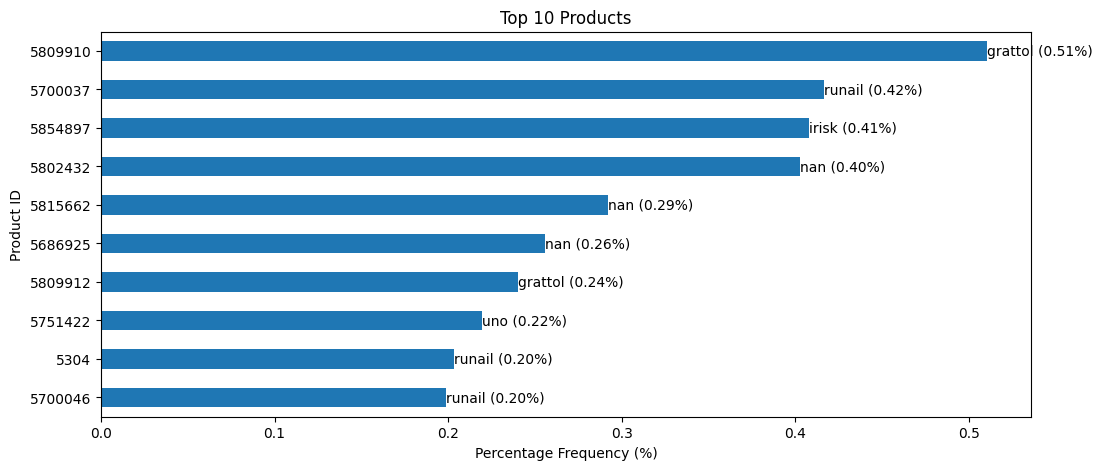

In [ ]:
# Trouver les 10 produits les plus fréquents
top_10_product = df['product_id'].value_counts(normalize=True).nlargest(10) * 100
top_product_ids = df['product_id'].value_counts().nlargest(10).index

# Associer chaque identifiant de produit à sa marque
product_to_brand = df.drop_duplicates('product_id').set_index('product_id')['brand'].to_dict()
top_products_df = df[df['product_id'].isin(top_product_ids)]

# Visualisations des 10 produits
plt.figure(figsize=(12, 5))
top_10_product.plot(kind='barh')
# top_products_df.groupby(['product_id', 'brand']).size().unstack().reindex(top_product_ids).plot(kind='barh', stacked=True, ax=plt.gca())

# Ajout du pourcentage de fréquence sur les barres ainsi que les informations sur la marque
for index, (product_id, value) in enumerate(top_10_product.items()):
    brand = product_to_brand[product_id]
    plt.text(value, index, f'{brand} ({value:.2f}%)', fontsize=10, va='center')

plt.title('Top 10 Products')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Product ID')
plt.gca().invert_yaxis()
plt.show()

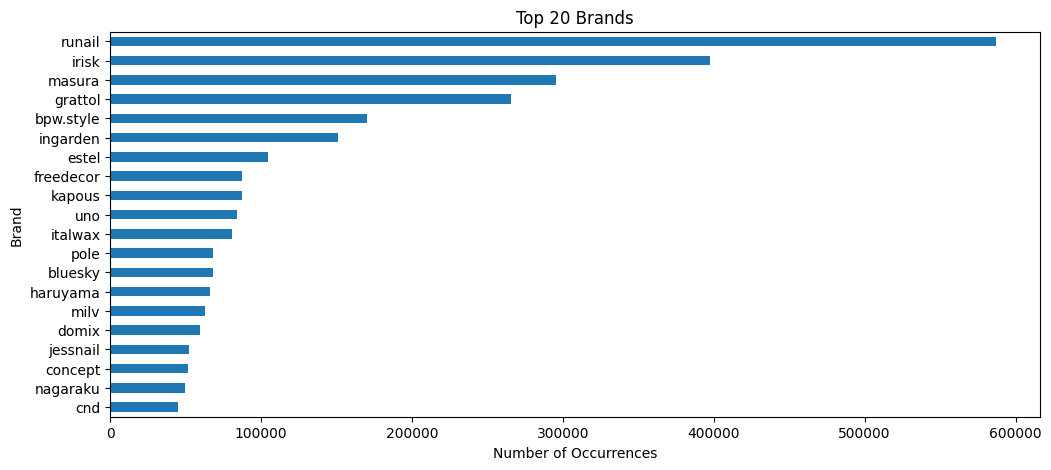

In [ ]:
# Trouver les 20 marques les plus fréquentes
top_20_brand = df['brand'].value_counts().nlargest(20)

# Visualisations des 20 marques
plt.figure(figsize=(12, 5))
top_20_brand.plot(kind='barh')

plt.title('Top 20 Brands')
plt.xlabel('Number of Occurrences')
plt.ylabel('Brand')
plt.gca().invert_yaxis()
plt.show()

**Déductions :**

*  *Variété des produits* : L'ensemble de données contient 45 318 identifiants de produit uniques, ce qui indique une grande variété de produits disponibles dans le magasin de cosmetique en ligne. Cette diversité peut potentiellement conduire à l'identification de groupes de clients distincts, avec des préférences pour différents types de produits.
*  *Articles populaires* : Un examen plus approfondi des 10 identifiants les plus fréquents peut donner des indications sur les produits ou marques populaires fréquemment achetés par les clients.
*  *Anomalie* : On observe **aucune** anomalie au niveau de la colonne 'product_id'. Les identifiants sont composés que de caractères numériques avec une longueur variant entre ( 7, 5, 4)

## Traitement des valeurs aberrantes

Dans le clustering K-means, l'algorithme est sensible à la fois à l'échelle des données et à la présence de valeurs aberrantes, car elles peuvent influencer de manière significative la position des centroïdes, ce qui peut conduire à des affectations incorrectes des clusters. Toutefois, compte tenu du contexte de ce projet, dont l'objectif final est de comprendre le comportement et les préférences des clients par le biais d'algorithmes de regroupement, il serait plus prudent d'aborder la question des valeurs aberrantes après la phase d'ingénierie des caractéristiques, au cours de laquelle nous créons un ensemble de données centrées sur le client. À ce stade, les données sont transactionnelles et la suppression des valeurs aberrantes risque d'éliminer des informations précieuses qui pourraient jouer un rôle crucial dans la segmentation des clients par la suite. Par conséquent, nous allons reporter le traitement des valeurs aberrantes et passer à l'étape suivante pour le moment.

In [ ]:
# Réinitialisation de l'index de l'ensemble de données nettoyé
df.reset_index(drop=True, inplace=True)

In [ ]:
print ("Le nombre de ligne initial était de 7 055 340, après nettoyage il est de",df.shape[0])

Le nombre de ligne initial était de 7 055 340, après nettoyage il est de 6898271


In [ ]:
df.to_csv("cleaned_eCommerce_cosmetics_shop.csv",index=False)

# Ingénierie des Caractéristiques (Feature Engineering)

Afin de créer un ensemble complet de données centrées sur le client pour le regroupement, les caractéristiques suivantes peuvent être élaborées à partir des données disponibles:

>  La nouvelle dataframe **customer_df**, contiendra à terme toutes les fonctionnalités basées sur le client que nous prévoyons de créer.

 *L'objectif du projet étant de regrouper les clients en fonction de leur comportement d'achat et de leurs préférences, nous garderons les événements des clienst qui ont au minimum un seul événement 'purchase'.*

In [ ]:
df = pd.read_csv('cleaned_eCommerce_cosmetics_shop.csv', index_col=0)
df.head()

In [ ]:
filtered_df = df.groupby('user_id').filter(lambda x: 'purchase' in x['event_type'].values)

filtered_df['event_date'] = filtered_df['event_time'].dt.date

# Filtrer le DataFrame pour n'inclure que les événements d'achat "purchase".
purchase_df = filtered_df[filtered_df['event_type'] == 'purchase']

## Caractéristiques RFM (Recency, Frequency, Monetary)

*  *Récence* : quelle est la date du dernier achat ? Une valeur de récence plus faible signifie que le client a acheté plus récemment, ce qui indique un engagement plus important avec le magasin.
*  *Fréquence* : quel est le nombre d'achats effectués par une période donnée ? Une valeur de fréquence plus élevée indique que le client interagit plus souvent avec l'entreprise, ce qui suggère une plus grande fidélité ou satisfaction.
*  *Montant* : quelle est la somme d'achats cumulées réalisés sur une période ? Les clients qui ont une valeur monétaire plus élevée ont contribué davantage à l'entreprise, ce qui indique leur valeur potentielle élevée au cours de leur vie.


> Ensemble, ces mesures permettent de comprendre le comportement d'achat et les préférences d'un client, ce qui est essentiel pour personnaliser les stratégies de marketing et créer un système de recommandation.

**Récence (R):**

Dans cette étape, nous nous attachons à comprendre à quand remonte l'achat d'un client. Ici, je vais définir la fonctionnalité suivante : Jours depuis le dernier achat.

Cette caractéristique représente le nombre de jours qui se sont écoulés depuis le dernier achat du client. Une valeur faible indique que le client a acheté récemment, ce qui implique un niveau d'engagement plus élevé avec l'entreprise, tandis qu'une valeur élevée peut indiquer une interruption ou une diminution de l'engagement. En comprenant la récurrence des achats, les entreprises peuvent adapter leurs stratégies de marketing pour réengager les clients qui n'ont pas fait d'achats depuis un certain temps, ce qui peut augmenter la rétention de la clientèle et favoriser la fidélité.

In [ ]:
# Grouper par 'user_id' et trouver la date d'achat la plus récente
customer_df = purchase_df.groupby('user_id')['event_date'].max().reset_index()

#  Trouver la date la plus récente dans l'ensemble du jeu de données
most_recent_date = df['event_date'].max()

# Convertir la colonne date et la valeur most_recent_date  en type datetime avant la soustraction
customer_df['event_date'] = pd.to_datetime(customer_df['event_date'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculer le score de récence
customer_df['days_since_last_purchase'] = (most_recent_date - customer_df['event_date']).dt.days

# Supprimer la colonne event_date
customer_df.drop(columns=['event_date'], inplace=True)

In [ ]:
customer_df.head()

,user_id,days_since_last_purchase
0,9794320,96
1,10079204,115
2,10280338,10
3,12055855,71
4,12936739,43


**Fréquence (F):**

Dans cette étape, je vais créer trois caractéristiques qui quantifient la fréquence de l'engagement d'un client:

-  *Total des achats* : Cette fonction représente le nombre total des achats effectuées par un client. Chaque ligne corresponds à l'achat d'un seul produits.

-  *produits uniques achetés* : Cette caractéristique représente le nombre de produits distincts achetés par un client, pour comprendre la diversité des comportements d'achat de produits des clients. Une valeur élevée indique que le client a des goûts ou des préférences variés et qu'il achète une large gamme de produits, tandis qu'une valeur faible peut indiquer une préférence ciblée ou spécifique.

In [ ]:
# Filtrer et compter le nombre d'achats par utilisateur
total_purchases = filtered_df[filtered_df['event_type'] == 'purchase'].groupby('user_id').size().reset_index(name='number_purchases')

# Filtrer et compter le nombre d'unique objet acheter par utilisateur
total_unique_products = filtered_df[filtered_df['event_type'] == 'purchase'].groupby('user_id')['product_id'].nunique().reset_index(name='unique_products_purchased')

In [ ]:
# Fusionner tous les DataFrames sur 'user_id'
customer_df = customer_df.merge(total_purchases, on='user_id').merge(total_unique_products, on='user_id')

In [ ]:
customer_df.sample(5)

,user_id,days_since_last_purchase,number_events,number_purchases,number_unique_products
31073,510492339,39,118,38,36
95916,602285209,10,41,9,9
13351,424904206,133,74,19,19
77661,580036429,90,9,3,3
66732,569169249,12,46,17,16


**Montant (M):**

Dans cette étape, je vais créer deux caractéristiques qui représentent l'aspect monétaire des transactions des clients :
-  *Dépenses totales* : Cette caractéristique représente le montant total dépensé par chaque client. Cette caractéristique est cruciale car elle permet d'identifier le revenu total généré par chaque client, ce qui est un indicateur direct de la valeur d'un client pour l'entreprise.
-  *Valeur moyenne des transactions* : Cette caractéristique est calculée en divisant le total des dépenses par le total des transactions pour chaque client. Elle indique la valeur moyenne d'une transaction effectuée par un client. Cette mesure est utile pour comprendre le comportement de dépense des clients par transaction, ce qui peut aider à adapter les stratégies de marketing et les offres aux différents segments de clients en fonction de leurs habitudes de dépenses moyennes.


In [ ]:
# Calculer le montant total dépensé par chaque client
total_spent = purchase_df.groupby('user_id')['price'].sum().reset_index(name='total_spent')

# Fusionner avec la dataframe customer_df
customer_df = customer_df.merge(total_spent, on='user_id')

# Calculer la valeur moyenne de la transaction pour chaque client
customer_df['average_amount_spent'] = customer_df['total_spent'] / customer_df['number_purchases']

customer_df.head()

,user_id,days_since_last_purchase,number_events,number_purchases,number_unique_products,total_spent,average_amount_spent
0,9794320,96,60,4,4,12.68,3.170000
1,10079204,115,4,2,2,25.81,12.905000
2,10280338,10,293,86,83,177.83,2.067791
3,12055855,71,11,4,4,16.54,4.135000
4,12936739,43,7,2,2,29.89,14.945000


## Caractéristiques comportementales

Au cours de cette étape, nous cherchons à comprendre et à saisir les habitudes d'achat et les comportements des clients. Ces fonctionnalités nous permettront de connaître les préférences des clients en ce qui concerne le moment où ils aiment faire leurs achats, ce qui peut être une information cruciale pour personnaliser leur expérience d'achat. Voici les fonctionnalités introduites:
-  *Nombre moyen de jours entre les achats* : Cette caractéristique représente le nombre moyen de jours qu'un client attend avant d'effectuer un autre achat.
-  *Jour d'achat préféré* : Il s'agit du jour de la semaine où le client fait le plus d'achats.
-  *Heure d'achat préférée* : il s'agit de l'heure de la journée à laquelle le client fait le plus d'achats.

L'identification de ces informations peut aider à optimiser le calendrier des campagnes de marketing et des promotions pour s'aligner sur les moments où les différents segments de clientèle sont les plus actifs, ce qui peut être une mesure cruciale pour le marketing ciblé et les promotions personnalisées.

In [ ]:
# On supprime les lignes avec des doublons sur 'user_id' et 'event_time' ce qui signifie l'achat d'un panier rempli de plusieurs articles
purchase_df_drop = purchase_df.drop_duplicates(subset=['user_id', 'event_time'])

# Calculer le nombre moyen de jours entre deux achats
purchase_df_drop['prev_event_time'] = purchase_df_drop.groupby('user_id')['event_time'].shift()
purchase_df_drop['days_between'] = (purchase_df_drop['event_time'] - purchase_df_drop['prev_event_time']).dt.days
purchase_df_drop['days_between'].fillna(0, inplace=True)  # Remplacer les valeurs NaN par 0 (pour les clients qui ont fait un seul achat)

avg_days_between = purchase_df_drop.groupby('user_id')['days_between'].mean().reset_index(name='avg_days_between_purchases')

# Déterminer la journée de shopping préférée
purchase_df_drop['event_day'] = purchase_df_drop['event_time'].dt.dayofweek
favorite_shopping_day = purchase_df_drop.groupby('user_id')['event_day'].agg(lambda x: x.mode()[0]).reset_index(name='favorite_shopping_day')

# Déterminer l'heure de shopping préférée
purchase_df_drop['event_hour'] = purchase_df_drop['event_time'].dt.hour
favorite_shopping_hour = purchase_df_drop.groupby('user_id')['event_hour'].agg(lambda x: x.mode()[0]).reset_index(name='favorite_shopping_hour')

# Fusionner toutes les caractéristiques dans customer_df
customer_df = customer_df.merge(avg_days_between, on='user_id').merge(favorite_shopping_day, on='user_id').merge(favorite_shopping_hour, on='user_id')


In [ ]:
customer_df.sample(10)

,user_id,days_since_last_purchase,number_events,number_purchases,number_unique_products,total_spent,average_amount_spent,avg_days_between_purchases,favorite_shopping_day,favorite_shopping_hour
66545,568998176,110,33,8,8,25.79,3.223750,0.0,0,13
79724,582618462,74,13,4,4,12.92,3.230000,0.0,1,19
9827,397617501,38,238,47,46,230.11,4.895957,21.0,0,4
102355,609431787,27,38,9,9,19.34,2.148889,0.0,6,13
56473,560757153,135,11,3,3,26.69,8.896667,0.0,3,6
20775,466185788,53,178,31,29,86.06,2.776129,43.5,1,16
23284,476287038,31,15,4,4,10.47,2.617500,0.0,2,8
98505,605183001,37,4,1,1,45.24,45.240000,0.0,3,18
65240,568068064,115,24,9,9,70.80,7.866667,0.0,2,8
36232,527724131,39,3,1,1,51.08,51.080000,0.0,1,8


## Aperçu sur ajout au panier sans achat

Dans cette étape, je vais analyser les shémas d'ajout au panier sans achat des clients afin d'obtenir des informations qui peuvent améliorer notre modèle de segmentation de la clientèle. Les fonctionnalités que je prévois d'introduire sont les suivantes :

-  *Fréquence d'annulation* : Cette mesure représente le nombre total d'événement d'ajout au panier sans achat en d'autres termes, les articles que le client a retiré et pas acheté.
-  *Taux d'annulation* : Il représente la proportion d'événement d'ajout au panier sans achat qu'un client a efféctués. Cette mesure donne une vue normalisée du comportement en matière d'annulation. Un taux d'annulation élevé peut être le signe d'un segment de clientèle insatisfait.

In [ ]:
# Compter le nombre d'événements réalisés par utilisateur
total_events = filtered_df.groupby('user_id').size().reset_index(name='number_events')

customer_df = customer_df.merge(total_events, on='user_id')

customer_df['remove_frequency'] = customer_df['number_events'] - customer_df['number_purchases']

customer_df['remove_rate'] = customer_df['remove_frequency'] / customer_df['number_events']

In [ ]:
customer_df.head()

,user_id,days_since_last_purchase,number_events,number_purchases,number_unique_products,total_spent,average_amount_spent,avg_days_between_purchases,favorite_shopping_day,favorite_shopping_hour,remove_frequency,remove_rate
0,9794320,96,60,4,4,12.68,3.170000,0.0,0,5,56,0.933333
1,10079204,115,4,2,2,25.81,12.905000,0.0,2,10,2,0.500000
2,10280338,10,293,86,83,177.83,2.067791,17.6,2,11,207,0.706485
3,12055855,71,11,4,4,16.54,4.135000,0.0,4,12,7,0.636364
4,12936739,43,7,2,2,29.89,14.945000,0.0,4,7,5,0.714286


## Saisonnalité et tendances

Dans cette étape on ajoutera quelques caractéristiques pour analyser les tendances des comportements d'achat des clients.
-  *Moyenne des dépenses mensuelles* : Il s'agit du montant moyen qu'un client dépense chaque mois. Une moyenne élevée indique que le client est plus dépensier, tandis qu'une moyenne plus basse peut indiquer que le client est plus soucieux de son budget.
-  *Variation standard des dépenses mensuelles* : indique la variabilité des dépenses mensuelles d'un client. Une valeur élevée indique que les dépenses du client fluctuent considérablement d'un mois à l'autre. En revanche, une valeur plus faible indique des habitudes de dépenses plus stables et cohérentes.
-  *Tendance des dépenses* : indique l'évolution des dépenses d'un client au fil du temps, représentée par la pente de la ligne de tendance ajustée à ses données de dépenses. Une tendance positive suggère une fidélité croissante, tandis qu'une tendance négative souligne la nécessité de réengagement, aidant ainsi à adapter les stratégies marketing pour maintenir ou modifier les habitudes de dépenses.

In [ ]:
# Extraire le mois et l'année de la date
purchase_df['year'] = purchase_df['event_time'].dt.year
purchase_df['month'] = purchase_df['event_time'].dt.month

# Calculer les dépenses mensuelles pour chaque client
monthly_spending = purchase_df.groupby(['user_id', 'year', 'month'])['price'].sum().reset_index()

# Calculer les habitudes d'achat saisonnières : Nous utilisons la fréquence mensuelle comme indicateur des habitudes d'achat saisonnières.
seasonal_buying_patterns = monthly_spending.groupby('user_id')['price'].agg(['mean', 'std']).reset_index().rename(columns={'mean': 'monthly_spending_mean', 'std': 'monthly_spending_std'})
seasonal_buying_patterns['monthly_spending_std'].fillna(0, inplace=True)

# Calculer l'évolution des dépenses
# Nous utilisons la pente de la ligne de tendance linéaire ajustée aux dépenses du client dans le temps comme indicateur de l'évolution des dépenses.
def calculate_trend(spend_data):
    # S'il y a plus d'un point de données, nous calculons la tendance à l'aide d'une régression linéaire
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    # S'il n'y a qu'un seul point de données, aucune tendance ne peut être calculée, d'où la valeur 0.
    else:
        return 0


# Appliquer la fonction calculate_trend pour trouver la tendance des dépenses pour chaque client.
spending_trends = monthly_spending.groupby('user_id')['price'].apply(calculate_trend).reset_index(name='spending_trend')

customer_df = customer_df.merge(seasonal_buying_patterns, on='user_id').merge(spending_trends, on='user_id')

In [ ]:
customer_df.sample(10)

,user_id,days_since_last_purchase,number_events,number_purchases,number_unique_products,total_spent,average_amount_spent,avg_days_between_purchases,favorite_shopping_day,favorite_shopping_hour,remove_frequency,remove_rate,monthly_spending_mean,monthly_spending_std,spending_trend
103607,610809247,24,14,14,14,77.52,5.537143,0.000000,2,14,0,0.000000,77.52,0.00000,0.00
59255,563021735,127,35,11,11,104.40,9.490909,0.000000,4,10,24,0.685714,104.40,0.00000,0.00
77581,579862968,83,4,2,2,18.89,9.445000,0.000000,6,10,2,0.500000,18.89,0.00000,0.00
99995,606843649,22,8,3,3,12.60,4.200000,0.000000,4,13,5,0.625000,12.60,0.00000,0.00
75184,577096505,92,11,3,3,26.02,8.673333,0.000000,4,13,8,0.727273,26.02,0.00000,0.00
51579,556939354,147,33,10,10,26.74,2.674000,0.000000,5,8,23,0.696970,26.74,0.00000,0.00
105791,613697924,13,59,15,15,121.47,8.098000,0.000000,5,6,44,0.745763,121.47,0.00000,0.00
11165,409368902,22,135,51,32,160.44,3.145882,7.333333,2,11,84,0.622222,80.22,24.43761,34.56
97384,604031068,39,35,15,15,38.56,2.570667,0.000000,1,9,20,0.571429,38.56,0.00000,0.00
84076,587713937,65,14,5,5,16.78,3.356000,0.000000,3,8,9,0.642857,16.78,0.00000,0.00


In [ ]:
customer_df['user_id'] = customer_df['user_id'].astype(object)

customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110518 entries, 0 to 110517
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   user_id                     110518 non-null  object 
 1   days_since_last_purchase    110518 non-null  int64  
 2   number_events               110518 non-null  int64  
 3   number_purchases            110518 non-null  int64  
 4   number_unique_products      110518 non-null  int64  
 5   total_spent                 110518 non-null  float64
 6   average_amount_spent        110518 non-null  float64
 7   avg_days_between_purchases  110518 non-null  float64
 8   favorite_shopping_day       110518 non-null  int32  
 9   favorite_shopping_hour      110518 non-null  int32  
 10  remove_frequency            110518 non-null  int64  
 11  remove_rate                 110518 non-null  float64
 12  monthly_spending_mean       110518 non-null  float64
 13  monthly_spendi

> Jusqu'à présent, nous avons créé un ensemble de données qui se concentre sur nos clients, en utilisant une variété de nouvelles fonctionnalités qui nous permettent de mieux comprendre leurs habitudes d'achat et leurs préférences.
> Maintenant que notre ensemble de données est prêt, nous pouvons passer à l'étape suivante de notre projet, qui consiste à établir une base solide pour la création de nos segments de clientèle.

In [ ]:
customer_df.to_csv('customer_df.csv', index=False)